# 1. Camera Calibration

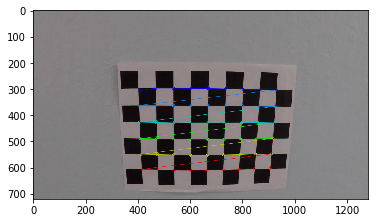

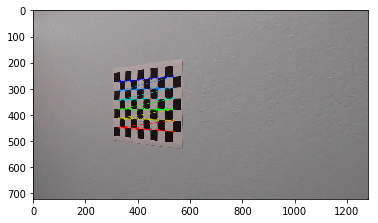

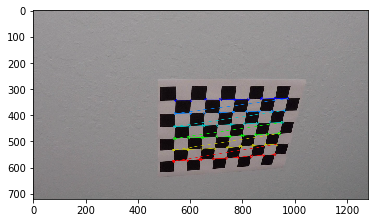

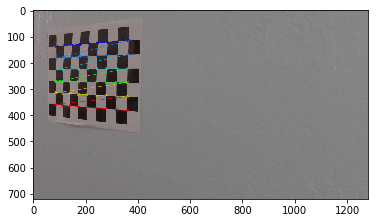

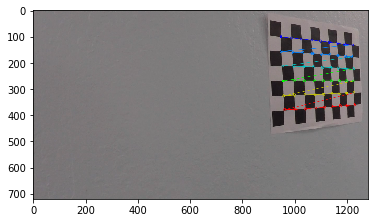

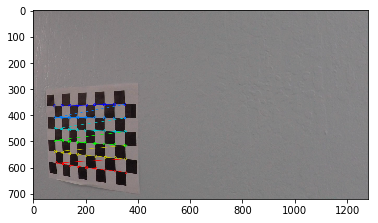

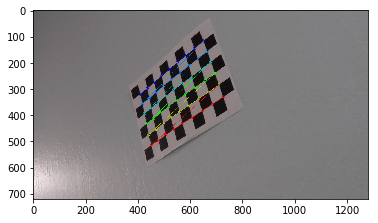

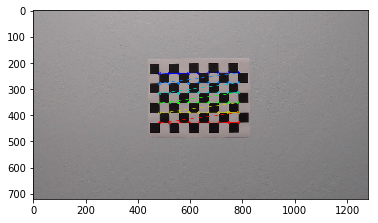

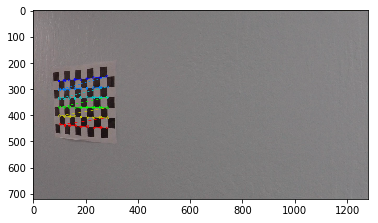

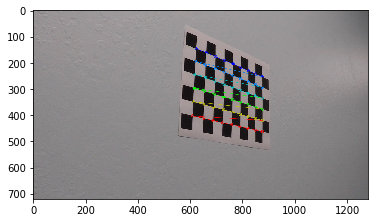

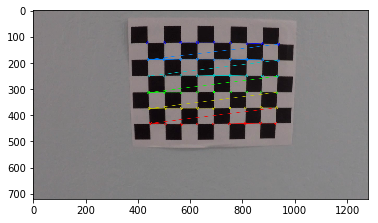

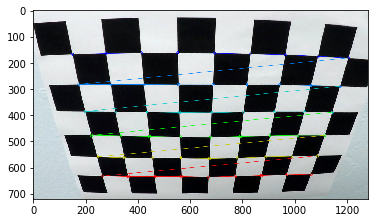

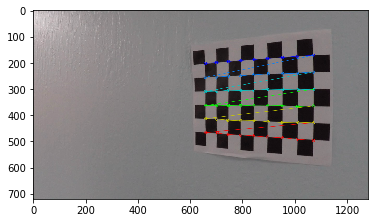

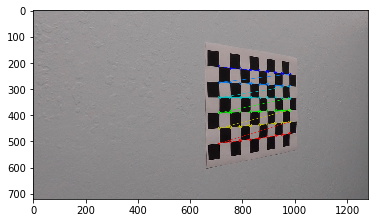

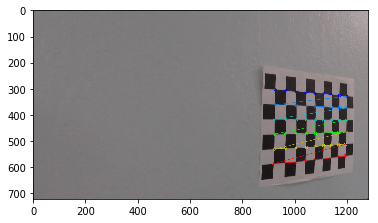

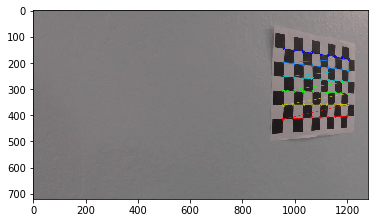

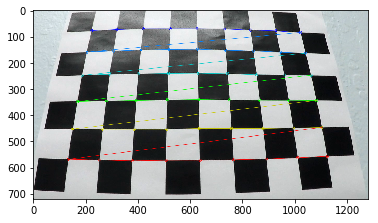

In [53]:
# Importing the packages for the helper functions
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
import shutil
import scipy.misc
import os
# Importing the pavkage used to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

#Camera calibration
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Intializing the arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Path of calibration images to do calibration
images = glob.glob('camera_cal/calibration*.jpg')

# Finding the for chessboard corners for all calibration images
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure(figsize=(10,10))
        fig = plt.figure()
        plt.imshow(img)

#Pickle the matrices
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
cal_pickle = {}
cal_pickle["mtx"] = mtx
cal_pickle["dist"] = dist
pickle.dump( cal_pickle, open( "camera_cal/calibration_pickle.p", "wb" ) )


In [54]:
# List all the test images
import os
os.listdir("test_images/")

['test1_output_final.png',
 'test4.jpg',
 'test1_sliding_window.png',
 'test5_output_final.png',
 'test2_sliding_window.png',
 'test2_output_final.png',
 'test6_undistort.png',
 'test3_sliding_window.png',
 'test4_undist.png',
 'straight_lines1.jpg',
 'test5.jpg',
 '.ipynb_checkpoints',
 'test1.jpg',
 'straight_lines1_sliding_window.png',
 'test4_sliding_window.png',
 'test3.jpg',
 'test2.jpg',
 'test3_output_final.png',
 'straight_lines2_output_final.png',
 'straight_lines2.jpg',
 'straight_lines1_output_final.png',
 'test5_sliding_window.png',
 'straight_lines2_sliding_window.png',
 'test4_output_final.png']

# 2.Distortion correction to raw images

In [55]:
# Helper function 
def undistort(img):
    # Copying the mtx[Camera Matrix] and dist[Distortion Coefficients] values from the pickle 
    cal_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb" ) )
    mtx = cal_pickle["mtx"]
    dist = cal_pickle["dist"]
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


Text(0.5,1,'undistorted')

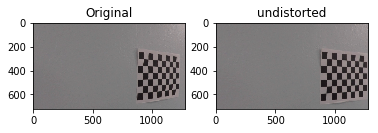

In [56]:
# Test undistortion on an image

#Distortion corrected camera calibration image
image_orig = 'camera_cal/calibration15.jpg'
img = cv2.imread(image_orig)
undist = undistort(img)

soln = scipy.misc.toimage(undist)
outfile = os.path.splitext(infile)[0] + "_undistort.png"   
soln.save(outfile, "PNG")

plt.figure(figsize=(20,20))
fig = plt.figure()
a=fig.add_subplot(1,2,1)
plt.imshow(img)
a.set_title('Original')

a=fig.add_subplot(1,2,2)
plt.imshow(undist)
a.set_title('undistorted')


# 3.Thresholding and Perspective Transformation

In [57]:
# Helper Function 

# Function to grayscale an image 
def greyscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use RGB2GRAY if you read an image with mpimg

# Function to do smoothening/blurring on an image
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Function to do sobel thresholding or masking on an image in x direction
def sobel_x_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = greyscale(img)
    # Take only Sobel x 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    #Calculate the absolute value of the x derivative:
    abs_sobelx = np.absolute(sobelx)
    #Convert the absolute value image to 8-bit:
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #Create binary image using thresholding
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

# Function to do Magnitude thresholding on an image
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = greyscale(img)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Function to do Direction thresholding on an image
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = greyscale(img)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
   
    return binary_output

# Function to do hsv color space thresholding on an image
def hsv_color_thresh(img, thresh_low, thresh_high):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    color_binary = np.zeros((img.shape[0], img.shape[1]))
    color_binary[(hsv[:,:,0] >= thresh_low[0]) & (hsv[:,:,0] <= thresh_high[0]) 
                  & (hsv[:,:,1] >= thresh_low[1])  & (hsv[:,:,1] <= thresh_high[1])  
                  & (hsv[:,:,2] >= thresh_low[2]) & (hsv[:,:,2] <= thresh_high[2])] = 1
    return color_binary 

# Function to do hls color space thresholding on an image
def hls_color_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    s = hls[:,:,2]
    s_binary = np.zeros_like(s)
    s_binary[(s > thresh[0]) & (s <= thresh[1])] = 1
    return s_binary

# Function to do Perspective Transformation on an image
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])
    
    # Hard coded number for the images
    src = np.float32([(300,720),(1100,720),(730,480),(580,480)])
    dst = np.float32([(300,720),(1100,720),(1100,0),(300,0)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    #inverse 
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #create a warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    unpersp = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, unpersp, Minv

#Function to do Thesholding and Perspective Transformation

def detect_lane(image, video_mode = False):
    #read image
    if video_mode == False:
        image = cv2.imread(image)
    
    # Undistort image
    undist = undistort(image)
    #print(undist.shape)
    
    # Define a kernel size and apply Gaussian smoothing
    apply_blur = True
    if apply_blur:
        kernel_size = 5
        undist = gaussian_blur(undist, kernel_size)

    # Define parameters for gradient thresholding
    sxbinary = sobel_x_thresh(undist, sobel_kernel=3, thresh = (22,100))
    mag_binary = mag_thresh(undist, sobel_kernel=3, thresh=(40, 100))
    dir_binary = dir_thresh(undist, sobel_kernel=15, thresh=(0.7, 1.3))
    
    # Define parameters for color thresholding
    s_binary = hls_color_thresh(undist, thresh=(90, 255))
    
    #You can combine various thresholding operations
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary1 = np.zeros_like(sxbinary)
    combined_binary1[(s_binary == 1) | (sxbinary == 1)] = 1
    
    combined_binary2 = np.zeros_like(sxbinary)
    combined_binary2[(s_binary == 1) | (sxbinary == 1)| (mag_binary == 1)] = 1
    
    # Apply perspective transform
    # Define points
    warped_im, _ , Minv = perspective_transform(combined_binary1)
    
    return undist, sxbinary, s_binary, combined_binary1, warped_im, Minv

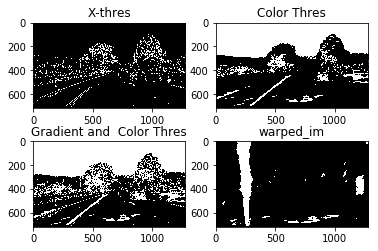

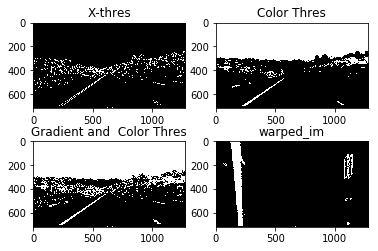

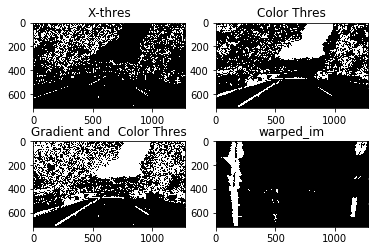

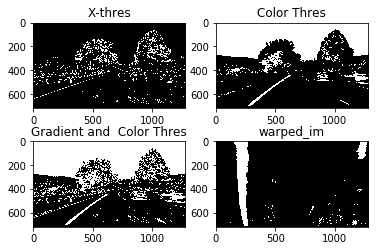

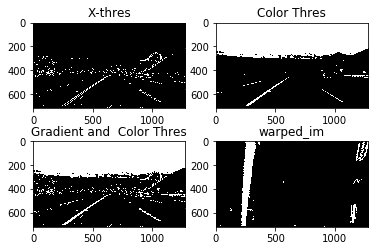

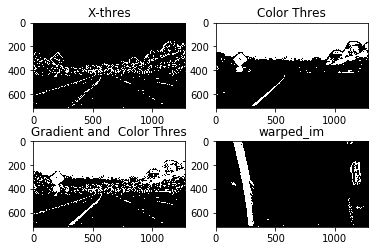

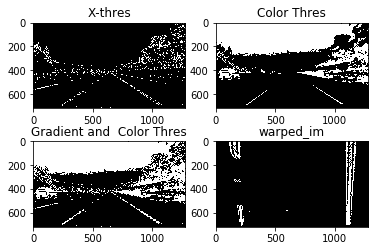

In [58]:
# Test THresholding and Perspective Transformation on an image
new_path = os.path.join("test_images/","*.jpg")
for infile in glob.glob(new_path):
    image = infile
    img = cv2.imread(image)
    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = detect_lane(image)

    plt.figure(figsize=(20,20))
    fig = plt.figure()

    a=fig.add_subplot(2,2,1)
    plt.imshow(sxbinary, cmap = 'Greys_r')
    a.set_title('X-thres')

    a=fig.add_subplot(2,2,2)
    plt.imshow(s_binary, cmap = 'Greys_r')
    a.set_title('Color Thres')
    
    a=fig.add_subplot(2,2,3)
    plt.imshow(combined_binary1, cmap = 'Greys_r')
    a.set_title('Gradient and  Color Thres')
    
    a=fig.add_subplot(2,2,4)
    plt.imshow(warped_im, cmap = 'Greys_r')
    a.set_title('warped_im')

    


# 4.Detecting the Lane Lines

In [59]:
# Helper Functions
# Function to do the SLIDING WINDOW APPROACH
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    # Highest value before 640
    leftx_base = np.argmax(histogram[:midpoint])
    # Highest after before 640
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# Function to do the Fitting of the line from coordinates found by SLIDING WINDOW APPROACH
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return leftx, lefty, left_fit, right_fit, out_img

# Function to do the Fitting of the line from coordinates found by Search by prior method
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

# Function to do the Search by prior knowledge of the SLIDING WINDOW APPROACH
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
   
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return left_fitx, right_fitx, ploty, left_fit_new , right_fit_new, result



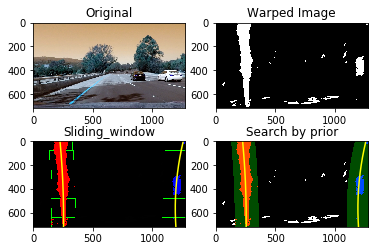

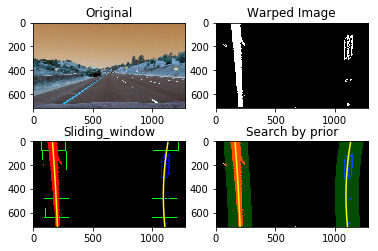

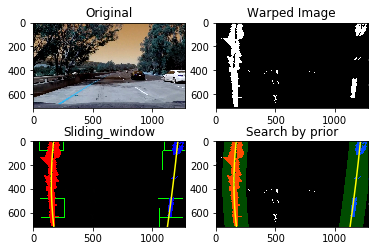

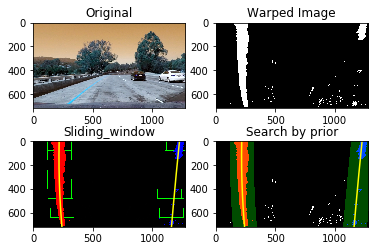

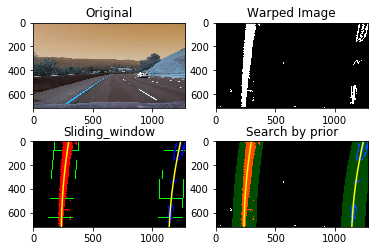

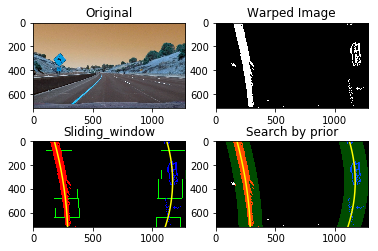

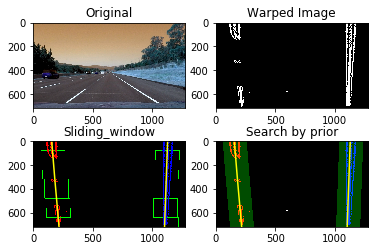

In [60]:

# Test detection of the lanes on an image

new_path = os.path.join("test_images/","*.jpg")
for infile in glob.glob(new_path):
    image = infile
    img = cv2.imread(image)
    undist = undistort(img)
    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = detect_lane(image)
    #left_fit, right_fit, out_img = fit_lines(warped_im)
    #left_fit_new, right_fit_new = fit_continuous(left_fit, right_fit, warped_im, plot = True)
    leftx, lefty, left_fit, right_fit, out_img = fit_polynomial(warped_im)
    left_fitx, right_fitx, ploty, left_fit_new , right_fit_new, result = search_around_poly(warped_im)
    
    soln = scipy.misc.toimage(out_img)
    outfile = os.path.splitext(infile)[0] + "_sliding_window.png"   
    soln.save(outfile, "PNG")

    plt.figure(figsize=(20,20))
    fig = plt.figure()
    a=fig.add_subplot(2,2,1)
    plt.imshow(img)
    a.set_title('Original')

    a=fig.add_subplot(2,2,2)
    plt.imshow(warped_im, cmap = 'Greys_r')
    a.set_title('Warped Image')  
 
    a=fig.add_subplot(2,2,3)
    plt.imshow(out_img, cmap = 'Greys_r')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    a.set_title('Sliding_window') 

    a=fig.add_subplot(2,2,4)
    plt.imshow(result, cmap = 'Greys_r')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    a.set_title('Search by prior') 
    

# 5.Output visual display of the lane boundaries,numerical estimation of lane curvature and vehicle position.

In [61]:
# Helper Functions

# Function to Calculate the Curvature
def cal_curvature(left_fit, right_fit, binary_warped, print_data = True):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Define left and right lanes in pixels
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Identify new coefficients in metres
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Calculation of center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    # Lane center as mid of left and right lane bottom
                            
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    
    if print_data == True:
    #Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm', center, 'm')

    return left_curverad, right_curverad, center

# Function to add the text to the output image
def add_text_to_image(img, left_cur, right_cur, center):
    
    cur = (left_cur + right_cur)/2.

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % cur, (50, 50), font, 1, (255, 255, 255), 2)

    left_or_right = "left" if center < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(center), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)

# Function to display of the lane boundaries and numerical estimation of lane curvature and vehicle position 
def draw_lines(undist, warped,left_fit, right_fit, left_cur, right_cur, center, show_img = True ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    add_text_to_image(result, left_cur, right_cur, center)
    
    return result

2101.95179101 m 783.256499642 m 0.550657562225 m
6396.67208239 m 866.965202203 m 0.0479581225472 m
1035.91136078 m 3768.69479477 m 0.293764178372 m
2244.19517454 m 8936.90509623 m 0.450537537325 m
1601.59532399 m 1299.22721904 m 0.689868088667 m
971.536532061 m 388.150073597 m 0.0593111572012 m
20214.3121872 m 135403.505497 m 0.0189938538716 m


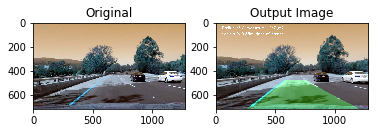

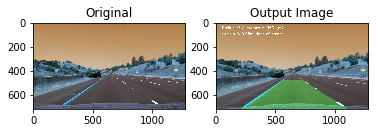

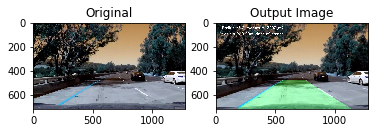

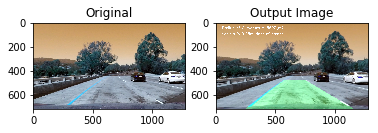

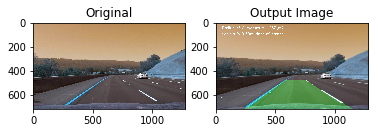

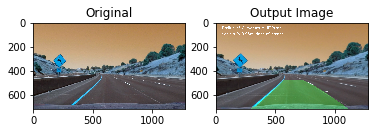

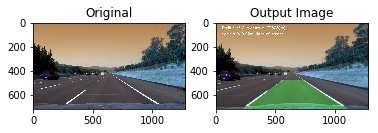

In [62]:
# Test for the final output on an image
new_path = os.path.join("test_images/","*.jpg")

for infile in glob.glob(new_path):
    image = infile
    img = cv2.imread(image)
    undist = undistort(img)
    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = detect_lane(image)
    leftx, lefty, left_fit, right_fit, out_img = fit_polynomial(warped_im)
    left_cur, right_cur, center = cal_curvature(left_fit, right_fit, warped_im, print_data = True)
    result  = draw_lines(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, show_img = False)
    
    soln = scipy.misc.toimage(result)
    outfile = os.path.splitext(infile)[0] + "_output_final.png"   
    soln.save(outfile, "PNG")
         
    plt.figure(figsize=(20,20))
    fig = plt.figure()
    a=fig.add_subplot(1,2,1)
    plt.imshow(img)
    a.set_title('Original')

        
    a=fig.add_subplot(1,2,2)
    plt.imshow(result)
    a.set_title('Output Image') 
    

# 6.Sanity Check

In [63]:
# Helper Function

# Function to do the specified checks mentioned in the project
def sanity_check(left_fit, right_fit):
    #Performs a sanity check on the lanes

    #1. Check if left and right fit returned a value
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines >= 150 and delta_lines <=430: #apprrox delta in pixels
            status = True
        else:
            status = False
        
        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        L_0 = 2*left_fit[0]*360+left_fit[1]
        R_0 = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(L_0-R_0)
        
         # Calculate slope of left and right lanes at top of y (i.e. 720)
        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        delta_slope_top =  np.abs(L_1-R_1)
        
        #Check if lines are parallel at the middle
        
        if delta_slope_mid<=0.1:
            status = True
        else:
            status = False
            
    return status

# 7.Tracking

In [64]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        # Done using the sanity_check and implemented in process_image function
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_left_xfitted = []
        self.recent_right_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.left_bestx = None 
        self.right_bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_left_fit = None  
        self.best_right_fit = None 
        #polynomial coefficients for the most recent fit
        self.current_right_fit = [np.array([False])]  
        self.current_right_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.left_radius_of_curvature = None 
        self.right_radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.left_allx = None 
        self.right_allx = None
        #y values for detected line pixels
        self.left_ally = None 
        self.right_ally = None
        
    def undistort(self,img):
        # Copying the mtx[Camera Matrix] and dist[Distortion Coefficients] values from the pickle 
        cal_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb" ) )
        mtx = cal_pickle["mtx"]
        dist = cal_pickle["dist"]
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        return undist
    
    # Function to grayscale an image 
    def greyscale(self,img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Or use RGB2GRAY if you read an image with mpimg

    # Function to do smoothening/blurring on an image
    def gaussian_blur(self,img, kernel_size):
        """Applies a Gaussian Noise kernel"""
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    # Function to do sobel thresholding or masking on an image in x direction
    def sobel_x_thresh(self,img, sobel_kernel=3, thresh=(0, 255)):
        gray = greyscale(img)
        # Take only Sobel x 
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        #Calculate the absolute value of the x derivative:
        abs_sobelx = np.absolute(sobelx)
        #Convert the absolute value image to 8-bit:
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        #Create binary image using thresholding
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return sxbinary

    # Function to do Magnitude thresholding on an image
    def mag_thresh(self, img, sobel_kernel=3, thresh=(0, 255)):
        # Convert to grayscale
        gray = greyscale(img)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

        # Return the binary image
        return binary_output

    # Function to do Direction thresholding on an image
    def dir_thresh(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):

        gray = greyscale(img)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)

        dir_grad = np.arctan2(abs_sobely, abs_sobelx)

        binary_output = np.zeros_like(dir_grad)
        binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1

        return binary_output

    # Function to do hsv color space thresholding on an image
    def hsv_color_thresh(self, img, thresh_low, thresh_high):
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        color_binary = np.zeros((img.shape[0], img.shape[1]))
        color_binary[(hsv[:,:,0] >= thresh_low[0]) & (hsv[:,:,0] <= thresh_high[0]) 
                      & (hsv[:,:,1] >= thresh_low[1])  & (hsv[:,:,1] <= thresh_high[1])  
                      & (hsv[:,:,2] >= thresh_low[2]) & (hsv[:,:,2] <= thresh_high[2])] = 1
        return color_binary 

    # Function to do hls color space thresholding on an image
    def hls_color_thresh(self, img, thresh=(0, 255)):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

        s = hls[:,:,2]
        s_binary = np.zeros_like(s)
        s_binary[(s > thresh[0]) & (s <= thresh[1])] = 1
        return s_binary

    # Function to do Perspective Transformation on an image
    def perspective_transform(self, img):
        img_size = (img.shape[1], img.shape[0])

        # Hard coded number for the images
        src = np.float32([(300,720),(1100,720),(730,480),(580,480)])
        dst = np.float32([(300,720),(1100,720),(1100,0),(300,0)])

        M = cv2.getPerspectiveTransform(src, dst)

        #inverse 
        Minv = cv2.getPerspectiveTransform(dst, src)

        #create a warped image
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

        unpersp = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)

        return warped, unpersp, Minv

    #Function to do Thesholding and Perspective Transformation

    def detect_lane(self, image, video_mode = False):
        #read image
        if video_mode == False:
            image = cv2.imread(image)

        # Undistort image
        undist = undistort(image)
        #print(undist.shape)

        # Define a kernel size and apply Gaussian smoothing
        apply_blur = True
        if apply_blur:
            kernel_size = 5
            undist = gaussian_blur(undist, kernel_size)

        # Define parameters for gradient thresholding
        sxbinary = sobel_x_thresh(undist, sobel_kernel=3, thresh = (22,100))
        mag_binary = mag_thresh(undist, sobel_kernel=3, thresh=(40, 100))
        dir_binary = dir_thresh(undist, sobel_kernel=15, thresh=(0.7, 1.3))

        # Define parameters for color thresholding
        s_binary = hls_color_thresh(undist, thresh=(90, 255))

        #You can combine various thresholding operations

        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

        # Combine the two binary thresholds
        combined_binary1 = np.zeros_like(sxbinary)
        combined_binary1[(s_binary == 1) | (sxbinary == 1)] = 1

        combined_binary2 = np.zeros_like(sxbinary)
        combined_binary2[(s_binary == 1) | (sxbinary == 1)| (mag_binary == 1)] = 1

        # Apply perspective transform
        # Define points
        warped_im, _ , Minv = perspective_transform(combined_binary1)

        return undist, sxbinary, s_binary, combined_binary1, warped_im, Minv  

    # Function to do the SLIDING WINDOW APPROACH
    def find_lane_pixels(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        # Highest value before 640
        leftx_base = np.argmax(histogram[:midpoint])
        # Highest after before 640
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img

    # Function to do the Fitting of the line from coordinates found by SLIDING WINDOW APPROACH
    def fit_polynomial(binary_warped):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        self.recent_left_xfitted.append(left_fitx)
        self.recent_right_xfitted.append(right_fitx)
        
        self.current_left_fit = [np.array([left_fit[0],left_fit[1],left_fit[2]])] 
        self.current_right_fit = [np.array([right_fit[0],right_fit[1],right_fit[2]])]
        
        if (self.best_left_fit == 0 | self.best_right_fit == 0):
            poly_coeff_left = [np.array([False])]   
            poly_coeff_right = [np.array([False])]
        else :
            n = len(self.best_left_fit)
            self.left_diffs = float(self.best_left_fit[n] - self.current_left_fit)
            self.right_diffs = self.best_right_fit[n] - self.current_right_fit
            
        self.best_left_fit = poly_coeff_left.append(self.current_left_fit)  
        self.best_right_fit = poly_coeff_right.append(self.current_right_fit) 
        
        return leftx, lefty, left_fit, right_fit, out_img

    # Function to do the Fitting of the line from coordinates found by Search by prior method
    def fit_poly(img_shape, leftx, lefty, rightx, righty):
         ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        return left_fitx, right_fitx, ploty

    # Function to do the Search by prior knowledge of the SLIDING WINDOW APPROACH
    def search_around_poly(binary_warped):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        if len(leftx) == 0:
            left_fit_new =[]
        else:
            left_fit_new = np.polyfit(lefty, leftx, 2)


        if len(rightx) == 0:
            right_fit_new =[]
        else:
            right_fit_new = np.polyfit(righty, rightx, 2)

        # Fit new polynomials
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()

        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        self.recent_left_xfitted.append(left_fitx)
        self.recent_right_xfitted.append(right_fitx)
        
        self.current_left_fit = [np.array([left_fit_new[0],left_fit_new[1],left_fit_new[2]])] 
        self.current_right_fit = [np.array([right_fit_new[0],right_fit_new[1],right_fit_new[2]])]
        
        if (self.best_left_fit == 0 | self.best_right_fit == 0):
            poly_coeff_left = [np.array([False])]   
            poly_coeff_right = [np.array([False])]
        else :
            n = len(self.best_left_fit)
            self.left_diffs = float(self.best_left_fit[n] - self.current_left_fit)
            self.right_diffs = self.best_right_fit[n] - self.current_right_fit
            
        self.best_left_fit = poly_coeff_left.append(self.current_left_fit)  
        self.best_right_fit = poly_coeff_right.append(self.current_right_fit) 
        return left_fitx, right_fitx, ploty, left_fit_new , right_fit_new, result

    # Function to Calculate the Curvature
    def cal_curvature(self, left_fit, right_fit, binary_warped, print_data = True):
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)

        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        #Define left and right lanes in pixels
        leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        #Identify new coefficients in metres
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        #Calculation of center
        #left_lane and right lane bottom in pixels
        left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
        right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
        # Lane center as mid of left and right lane bottom

        lane_center = (left_lane_bottom + right_lane_bottom)/2.
        center_image = 640
        center = (lane_center - center_image)*xm_per_pix #Convert to meters

        if print_data == True:
        #Now our radius of curvature is in meters
            print(left_curverad, 'm', right_curverad, 'm', center, 'm')
        
        self.left_radius_of_curvature = left_curverad 
        self.right_radius_of_curvature = right_curverad
        
        return left_curverad, right_curverad, center

    # Function to add the text to the output image
    def add_text_to_image(self, img, left_cur, right_cur, center):

        cur = (left_cur + right_cur)/2.

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, 'Radius of Curvature = %d(m)' % cur, (50, 50), font, 1, (255, 255, 255), 2)

        left_or_right = "left" if center < 0 else "right"
        cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(center), left_or_right), (50, 100), font, 1,
                    (255, 255, 255), 2)

    # Function to display of the lane boundaries and numerical estimation of lane curvature and vehicle position 
    def draw_lines(self, undist, warped,left_fit, right_fit, left_cur, right_cur, center, show_img = True ):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        # Fit new polynomials to x,y in world space
        left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
        right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        add_text_to_image(result, left_cur, right_cur, center)

        return result
    
    # Function to do the specified checks mentioned in the project
    def sanity_check(self, left_fit, right_fit):
        #Performs a sanity check on the lanes

        #1. Check if left and right fit returned a value
        if len(left_fit) ==0 or len(right_fit) == 0:
            status = False

        else:
            #Check distance b/w lines
            ploty = np.linspace(0, 20, num=10 )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            delta_lines = np.mean(right_fitx - left_fitx)
            self.line_base_pos = delta_lines 
            if delta_lines >= 150 and delta_lines <=430: #apprrox delta in pixels
                status = True
            else:
                status = False

            # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
            L_0 = 2*left_fit[0]*360+left_fit[1]
            R_0 = 2*right_fit[0]*360+right_fit[1]
            delta_slope_mid =  np.abs(L_0-R_0)

             # Calculate slope of left and right lanes at top of y (i.e. 720)
            L_1 = 2*left_fit[0]*720+left_fit[1]
            R_1 = 2*right_fit[0]*720+right_fit[1]
            delta_slope_top =  np.abs(L_1-R_1)

            #Check if lines are parallel at the middle

            if delta_slope_mid<=0.1:
                status = True
            else:
                status = False
            
            self.left_allx = leftx 
            self.right_allx = rightx
            #y values for detected line pixels
            self.left_ally = lefty 
            self.right_ally = righty 
            
        return status

    # Pipeline for processing images 

    def pipeline(self, image):
        global counter
        global last_left 
        global last_right
        global left_fit
        global right_fit

        undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = detect_lane(image, video_mode = True)   
        #left_fit_new, right_fit_new = fit_continuous(left_fit, right_fit, warped_im, plot = True)
        if counter == 0:
            leftx, lefty, left_fit, right_fit, out_img = fit_polynomial(warped_im)
        else:
            leftx, rightx, ploty, left_fit , right_fit, result = search_around_poly(warped_im)

        # Do Sanity check
        status =sanity_check(left_fit, right_fit)

        #Decide if to use calculated points
        if status == True:        
            #Save as last reliable fit
            last_left, last_right = left_fit, right_fit
            self.detected = True 
            counter+=1
        else:        #Use the last realible fit
            self.detected = False 
            left_fit, right_fit = last_left, last_right
        
        left_cur, right_cur, center = cal_curvature(left_fit, right_fit, warped_im, print_data = False)
        result  = draw_lines(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, show_img = False)
        
        self.left_bestx = np.mean(self.recent_left_xfitted)
        self.right_bestx = np.mean(self.recent_right_xfitted)   
        
        return result

# 8. Video File

In [65]:

# Pipeline for processing images 

def process_image(image):
    global counter
    global last_left 
    global last_right
    global left_fit
    global right_fit

    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = detect_lane(image, video_mode = True)   
    #left_fit_new, right_fit_new = fit_continuous(left_fit, right_fit, warped_im, plot = True)
    if counter == 0:
        leftx, lefty, left_fit, right_fit, out_img = fit_polynomial(warped_im)
    else:
        leftx, rightx, ploty, left_fit , right_fit, result = search_around_poly(warped_im)
    
    # Do Sanity check
    status =sanity_check(left_fit, right_fit)
    
    #Decide if to use calculated points
    if status == True:        
        #Save as last reliable fit
        last_left, last_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = last_left, last_right

    left_cur, right_cur, center = cal_curvature(left_fit, right_fit, warped_im, print_data = False)
    result  = draw_lines(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, show_img = False)   
    
    return result

In [68]:
from moviepy.editor import VideoFileClip
#Create video file pipeline
counter=0
output = 'test_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video test_project_video.mp4
[MoviePy] Writing video test_project_video.mp4



 12%|█▏        | 152/1261 [01:09<08:57,  2.06it/s]


 24%|██▍       | 303/1261 [02:20<07:20,  2.18it/s]


 36%|███▌      | 454/1261 [03:31<06:12,  2.17it/s]


 48%|████▊     | 605/1261 [04:43<05:24,  2.02it/s]


 60%|█████▉    | 756/1261 [05:56<03:55,  2.14it/s]


 72%|███████▏  | 907/1261 [07:08<02:44,  2.15it/s]


 84%|████████▍ | 1057/1261 [08:21<01:43,  1.98it/s]


 96%|█████████▌| 1205/1261 [09:33<00:26,  2.10it/s]


100%|█████████▉| 1260/1261 [10:00<00:00,  2.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_project_video.mp4 

CPU times: user 7min 42s, sys: 2.28 s, total: 7min 44s
Wall time: 10min 3s


In [67]:
#Create video file pipeline
from moviepy.editor import VideoFileClip
#Create video file pipeline
l=Line()
counter=0
output = 'test_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(l.pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)



[MoviePy] >>>> Building video test_challenge_video.mp4
[MoviePy] Writing video test_challenge_video.mp4



 27%|██▋       | 132/485 [00:57<02:34,  2.29it/s]


TypeError: expected non-empty vector for x

In [42]:
#Create video file pipeline
from moviepy.editor import VideoFileClip
#Create video file pipeline
counter=0
output = 'test_harder_challenge_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(l.pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)



[MoviePy] >>>> Building video test_harder_challenge_video.mp4
[MoviePy] Writing video test_harder_challenge_video.mp4



 25%|██▌       | 303/1200 [02:31<07:50,  1.91it/s]


 50%|█████     | 605/1200 [05:06<04:36,  2.16it/s]


 76%|███████▌  | 907/1200 [07:50<02:26,  2.00it/s]


100%|█████████▉| 1199/1200 [10:20<00:00,  1.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_harder_challenge_video.mp4 

CPU times: user 7min 37s, sys: 2.66 s, total: 7min 40s
Wall time: 10min 24s
